In [ ]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import shutil
import sys
import tqdm.notebook as tq
from collections import defaultdict

import torch
import torch.nn as nn
import re
import matplotlib.pyplot as plt

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import glob
file_names = glob.glob('/content/drive/MyDrive/GA Research Project - Covid Tweet Classification/Twitter_Covid_GAProject/Annotated Data/*.csv')
print(file_names)

Mounted at /content/drive
['/content/drive/MyDrive/GA Research Project - Covid Tweet Classification/Twitter_Covid_GAProject/Annotated Data/CNN_tweets_unique.csv', '/content/drive/MyDrive/GA Research Project - Covid Tweet Classification/Twitter_Covid_GAProject/Annotated Data/CDCFLu_tweets_unique.csv', '/content/drive/MyDrive/GA Research Project - Covid Tweet Classification/Twitter_Covid_GAProject/Annotated Data/CDCtravel_tweets_unique_.csv', '/content/drive/MyDrive/GA Research Project - Covid Tweet Classification/Twitter_Covid_GAProject/Annotated Data/CDCemergency_tweets_unique.csv', '/content/drive/MyDrive/GA Research Project - Covid Tweet Classification/Twitter_Covid_GAProject/Annotated Data/CDCgov_tweets_unique.csv']


In [ ]:
df_data = []
for file_name in file_names:
  temp = pd.read_csv(file_name)
  if 'CDCFLu' in file_name:
    temp = temp.head(50)
  else:
    temp = temp.head(499)
  df_data.append(temp)
df_data = pd.concat(df_data)
print(df_data.shape)
#df_data=df_data.head(500)
print(df_data["Category"].unique())
def clean_text(text):
    text = re.sub(r'RT\s@\w+:\s', '', text) # remove retweet text
    text = re.sub(r'https?:\/\/\S+', '', text) # remove URLs
    text = re.sub(r'&\w+;', '', text) # remove HTML entities
    text = re.sub(r'\d+', '', text) # remove numbers
    text = re.sub(r'\W+', ' ', text) # remove special characters
    text = text.lower() # convert to lowercase
    return text

df_data["clean_text"] = df_data["text"].apply(clean_text)

(2046, 13)
[nan 'Outbreak' 'Vaccine; Outbreak' 'Outbreak; Prevention; Vaccine'
 'Outbreak; Vaccine' 'Outbreak; Symptoms' 'Outbreak; Prevention' 'Vaccine'
 'Prevention' 'Outbreak; Vaccine; Prevention' 'Vaccine; Prevention'
 'Vaccine, Prevention; Symptoms' 'Vaccine, Outbreak' 'Travel; Outbreak'
 'Travel' 'Prevention, Travel' 'Travel; Prevention' 'Prevention; Travel'
 'Symptoms' 'Prevention; Outbreak' 'Prevention: Travel'
 'Prevention; travel' 'Prevntion' 'Outbreak ' 'Vaccine, Travel'
 'Outbreak; Travel' 'outbreak' 'Travel; prevention' 'Travel; Symptoms'
 'Ountbreak' 'outbreak ' 'prevention' ' Outbreak; Prevention'
 ' Prevention' 'Outbrek; Symptoms' 'Outbreak; symptoms'
 'Outbreak; prevention' 'prevention; outbreak' 'Prevention; Outbreak '
 'Outbreak Prevention' 'outbreak, prevention' 'Prevention; outbreak'
 'outbreak; prevention' 'travel; prevention' 'Symptoms; Prevention'
 'Prevention, Outbreak' 'Outbreak; Awarness' 'Prevention; Awarness'
 'Symptoms, Awarness' 'Outbreak;Awareness' 'Outb

In [ ]:
# Filtering the rare terms.
df_data_filtered = df_data.groupby("Category").filter(lambda x: len(x) >1)
df_data_filtered.shape
print(df_data_filtered["Category"])
df_data_filtered["Category"]=[''.join(i.split()).lower() for i in df_data_filtered["Category"]]

def filter_category(categories):
  #options = ['travel', 'outbreak','prevention','vaccine','symptoms']
  if ',' in categories:
    category_list = categories.split(',')
  elif ';' in categories:
    category_list = categories.split(';')
  else:
    category_list = [categories]

  #print(category_list)
  '''
  temp = []
  for item in category_list:
    item = item.strip().lower()
    if 'awarness' == item:
      continue
    temp.append(item.strip())
  #print('temp =', temp)
  '''
  return category_list

2                  Outbreak
4                  Outbreak
12        Vaccine; Outbreak
28        Outbreak; Vaccine
39                 Outbreak
               ...         
487    Prevention; Awarness
488              Prevention
490                Symptoms
492              Prevention
496                Symptoms
Name: Category, Length: 938, dtype: object


In [ ]:
df_data_filtered["Category"] = df_data_filtered["Category"].apply(filter_category)

labels=[item for item in df_data_filtered["Category"]]

print(labels)

[['outbreak'], ['outbreak'], ['vaccine', 'outbreak'], ['outbreak', 'vaccine'], ['outbreak'], ['outbreak', 'symptoms'], ['outbreak', 'vaccine'], ['outbreak', 'vaccine'], ['vaccine', 'outbreak'], ['vaccine', 'outbreak'], ['outbreak'], ['vaccine', 'outbreak'], ['vaccine', 'outbreak'], ['vaccine', 'outbreak'], ['vaccine', 'outbreak'], ['outbreak', 'prevention'], ['vaccine'], ['vaccine', 'outbreak'], ['prevention'], ['vaccine'], ['vaccine', 'outbreak'], ['vaccine'], ['outbreak'], ['vaccine'], ['outbreak'], ['outbreak'], ['outbreak', 'vaccine'], ['outbreak', 'prevention'], ['outbreak'], ['outbreak'], ['vaccine', 'outbreak'], ['outbreak'], ['vaccine'], ['outbreak'], ['outbreak'], ['vaccine', 'outbreak'], ['vaccine', 'prevention'], ['outbreak'], ['outbreak'], ['outbreak'], ['vaccine', 'outbreak'], ['vaccine', 'outbreak'], ['outbreak'], ['outbreak'], ['vaccine', 'outbreak'], ['outbreak', 'prevention'], ['outbreak'], ['outbreak'], ['outbreak'], ['outbreak'], ['vaccine', 'outbreak'], ['vaccine'],

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
mlb = MultiLabelBinarizer()
a = mlb.fit_transform(labels)
pd.DataFrame(a, columns=mlb.classes_)
final_text=[text for text  in df_data_filtered["clean_text"]]

labels=[lab for lab  in a]

lab,c =np.unique(a, axis=0, return_counts=True)

print(lab,c)
print(mlb.classes_)
print("total",sum(c))
print(final_text[0])

[[0 0 0 0 0 1]
 [0 0 0 0 1 0]
 [0 0 0 1 0 0]
 [0 0 1 0 0 0]
 [0 0 1 0 0 1]
 [0 0 1 0 1 0]
 [0 0 1 1 0 0]
 [0 1 0 0 0 0]
 [0 1 0 0 0 1]
 [0 1 0 0 1 0]
 [0 1 0 1 0 0]
 [0 1 1 0 0 0]
 [1 0 1 0 0 0]
 [1 1 0 0 0 0]] [ 12 142  18 207   2  50   2 341  27   8  11 100   5  13]
['awarness' 'outbreak' 'prevention' 'symptoms' 'travel' 'vaccine']
total 938
b europe is now trading more goods with china than the united states a sign of how the pandemic is transforming the global economy the overall value of eu china goods trade last year was billion about billion more than between the eu and the us 


In [ ]:
lnew=np.zeros((len(labels),5));
#print("before",labels)
for i,l in enumerate(labels):
  lnew[i,:]=l[1:]
final_label=lnew

In [ ]:
lnew[:10], len(lnew)

(array([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 1.],
        [1., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0.],
        [1., 0., 1., 0., 0.],
        [1., 0., 0., 0., 1.],
        [1., 0., 0., 0., 1.],
        [1., 0., 0., 0., 1.],
        [1., 0., 0., 0., 1.]]),
 938)

In [ ]:
len(final_text)

938

## Using Bert Embeddings

In [ ]:
from transformers import BertTokenizer,BertModel
# Load pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
# Test the tokenizer
test_text = "We are testing BERT tokenizer."
# generate encodings
encodings = tokenizer.encode_plus(test_text,
                                  add_special_tokens = True,
                                  max_length = 50,
                                  truncation = True,
                                  padding = "max_length",
                                  return_attention_mask = True,
                                  return_tensors = "pt")

In [ ]:
encodings

{'input_ids': tensor([[  101,  2057,  2024,  5604, 14324, 19204, 17629,  1012,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]])}

In [ ]:
type(final_text), type(lnew)

(list, numpy.ndarray)

In [ ]:
final_label[:5], len(final_label)

(array([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 1.],
        [1., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0.]]),
 938)

In [ ]:
len(final_text), final_label.shape

(938, (938, 5))

In [ ]:
test_split = 0.2

# Create DataFrame with final_text and final_label
df = pd.DataFrame({'txt': final_text, 'lab': final_label.tolist()})

# Initial train and test split
train_df, test_df = train_test_split(
    df,
    test_size=test_split,
    random_state = 95
)



In [ ]:
# Split train_df and test_df into X_train, y_train, X_test, and y_test
X_train_text = train_df['txt'].tolist()
y_train_labels = train_df['lab'].tolist()

X_test_text = test_df['txt'].tolist()
y_test_labels = test_df['lab'].tolist()

In [ ]:
len(X_train_text), len(y_train_labels), len(X_test_text), len(y_test_labels)

(750, 750, 188, 188)

In [ ]:
df.head()

,txt,lab
0,b europe is now trading more goods with china ...,"[1.0, 0.0, 0.0, 0.0, 0.0]"
1,b ryan reynolds and blake lively have once aga...,"[1.0, 0.0, 0.0, 0.0, 0.0]"
2,b states will receive more doses of covid vacc...,"[1.0, 0.0, 0.0, 0.0, 1.0]"
3,b here s what s in house democrats stimulus re...,"[1.0, 0.0, 0.0, 0.0, 1.0]"
4,b house democrats unveil trillion covid relief...,"[1.0, 0.0, 0.0, 0.0, 0.0]"


In [ ]:
X_train_text[0],y_train_labels[0]

('social distancing to reduce the spread of covid may increase the risk of domestic family violence as more time is spent in the home find resources on how to stay safe ',
 [1.0, 1.0, 0.0, 0.0, 0.0])

In [ ]:
# Define a function to generate BERT embeddings for text data
def generate_bert_embeddings(text_data):
    # Tokenize text data
    tokenized_data = tokenizer(text_data, padding=True, truncation=True, return_tensors='pt')

    # Generate BERT embeddings
    with torch.no_grad():
        outputs = model(**tokenized_data)

    # Extract BERT embeddings from the output
    bert_embeddings = outputs.last_hidden_state.numpy()

    return bert_embeddings

In [ ]:
# Convert text data to BERT embeddings
X_train_embeddings = generate_bert_embeddings(X_train_text)
X_test_embeddings = generate_bert_embeddings(X_test_text)

# Convert y_train and y_test labels to numpy arrays
y_train = np.array(y_train_labels)
y_test = np.array(y_test_labels)

In [ ]:
np.unique(y_train)

array([0., 1.])

In [ ]:
X_train_embeddings.shape,X_test_embeddings.shape

((750, 96, 768), (188, 62, 768))

In [ ]:
# Pad test data sequences
from keras.preprocessing.sequence import pad_sequences

X_test_embeddings_padded = pad_sequences(X_test_embeddings, maxlen=X_train_embeddings.shape[1], padding='post')

In [ ]:
X_train_embeddings.shape,X_test_embeddings_padded.shape

((750, 96, 768), (188, 96, 768))

In [ ]:
from keras.layers import Input, Embedding, SpatialDropout1D, GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, Dense, Dropout,Conv1D, MaxPooling1D
from keras.models import Model

In [ ]:
!pip install keras-tcn
!pip install keras-tcn --no-dependencies

In [ ]:
from tcn import TCN

In [ ]:
from sklearn.metrics import f1_score

def f1_metric(y_true, y_pred):
    y_pred = tf.round(y_pred)
    tp = tf.reduce_sum(y_true * y_pred, axis=0)
    fp = tf.reduce_sum((1 - y_true) * y_pred, axis=0)
    fn = tf.reduce_sum(y_true * (1 - y_pred), axis=0)
    precision = tp / (tp + fp + tf.keras.backend.epsilon())
    recall = tp / (tp + fn + tf.keras.backend.epsilon())
    f1 = 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())
    return tf.reduce_mean(f1)


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
y_train[:2]

array([[1., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [ ]:
# Convert y_train to numpy array outside the function and flatten it
y_train_np_flattened = np.array(y_train).flatten()

# Calculate class weights
class_labels = np.unique(y_train_np_flattened)

In [ ]:
#class_labels

array([0., 1.])

In [ ]:
# Compute class weights
#computed_class_weights = compute_class_weight(classes=class_labels, class_weight="balanced", y=y_train_np_flattened)
NUM_CLASSES = len(train_df['lab'].iloc[0])

In [ ]:
# Calculate class weights for each class dimension
class_weights = {}
for i in range(NUM_CLASSES):
    class_weights[i] = compute_class_weight('balanced', classes=[0, 1], y=y_train[:, i])


In [ ]:
class_weights

{0: array([1.06837607, 0.93984962]),
 1: array([0.83333333, 1.25      ]),
 2: array([ 0.51724138, 15.        ]),
 3: array([0.6377551 , 2.31481481]),
 4: array([ 0.5259467 , 10.13513514])}

 the class weights you're passing have two values for each class dimension. The class weights should be a scalar value for each class, indicating the weight to be applied to instances of that class.

To resolve this issue, you need to use the class weights as scalars, not arrays. You can achieve this by taking the mean of the class weights arrays you computed earlier.

In [ ]:
# Convert class weights arrays to scalars
class_weights = {class_idx: np.mean(weights) for class_idx, weights in class_weights.items()}

In [ ]:
# Define TCN model with 5 TCN layers
def tcn_model(output_dim=None, max_length=None):
    inp = Input(shape=(max_length, output_dim))

    # since we are using pre-generated BERT embeddings there is no need for the Embedding layer

    x = SpatialDropout1D(0.1)(inp)
    x = TCN(128, dilations=[1, 2, 4], return_sequences=True, activation='relu', name='tcn1')(x)
    x = TCN(128, dilations=[1, 2, 4], return_sequences=True, activation='relu', name='tcn2')(x)
    x = TCN(128, dilations=[1, 2, 4], return_sequences=True, activation='relu', name='tcn3')(x)
    x = TCN(64, dilations=[1, 2, 4], return_sequences=True, activation='relu', name='tcn4')(x)
    x = TCN(64, dilations=[1, 2, 4], return_sequences=True, activation='relu', name='tcn5')(x)

    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)

    conc = concatenate([avg_pool, max_pool])
    conc = Dense(16, activation="relu")(conc)
    conc = Dropout(0.1)(conc)
    outp = Dense(NUM_CLASSES, activation="sigmoid")(conc)

    model = Model(inputs=inp, outputs=outp)

    # Compile the model without the class_weight parameter
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[f1_metric, "accuracy"])

    return model


In [ ]:
# Define constants
MAX_LENGTH = max(X_train_embeddings.shape[1], X_test_embeddings_padded.shape[1])
VOCAB_SIZE = tokenizer.vocab_size
OUTPUT_DIM = X_train_embeddings.shape[2]
NUM_EPOCHS = 50
BATCH_SIZE = 32
NUM_CLASSES = len(train_df['lab'].iloc[0])

In [ ]:
print(OUTPUT_DIM), print(MAX_LENGTH), print(NUM_CLASSES)

768
96
5


(None, None, None)

In [ ]:
# Compile the model
model = tcn_model(output_dim=OUTPUT_DIM, max_length=MAX_LENGTH)

In [ ]:
# Train the model
history = model.fit(
    X_train_embeddings,  # BERT embeddings for training data
    y_train,             # Labels for training data
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test_embeddings_padded, y_test),
    class_weight=class_weights  # Pass computed class weights here
)

Epoch 1/50
24/24 [==============================] - 53s 1s/step - loss: 10.9724 - f1_metric: 0.1419 - accuracy: 0.4013 - val_loss: 0.5193 - val_f1_metric: 0.1403 - val_accuracy: 0.5372
Epoch 2/50
24/24 [==============================] - 16s 671ms/step - loss: 0.6747 - f1_metric: 0.0941 - accuracy: 0.4680 - val_loss: 0.5721 - val_f1_metric: 0.0072 - val_accuracy: 0.5426
Epoch 3/50
24/24 [==============================] - 17s 715ms/step - loss: 0.6640 - f1_metric: 0.1004 - accuracy: 0.4720 - val_loss: 0.5392 - val_f1_metric: 0.0000e+00 - val_accuracy: 0.4149
Epoch 4/50
24/24 [==============================] - 17s 727ms/step - loss: 0.6528 - f1_metric: 0.0842 - accuracy: 0.4960 - val_loss: 0.4989 - val_f1_metric: 0.0000e+00 - val_accuracy: 0.5372
Epoch 5/50
24/24 [==============================] - 17s 715ms/step - loss: 0.6455 - f1_metric: 0.0804 - accuracy: 0.5080 - val_loss: 0.5099 - val_f1_metric: 0.0585 - val_accuracy: 0.5372
Epoch 6/50
24/24 [==============================] - 18s 760

In [ ]:
import matplotlib.pyplot as plt

# Get training history
train_loss = history.history['loss']
f1_metric = history.history['f1_metric']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']
train_acc = history.history['accuracy']

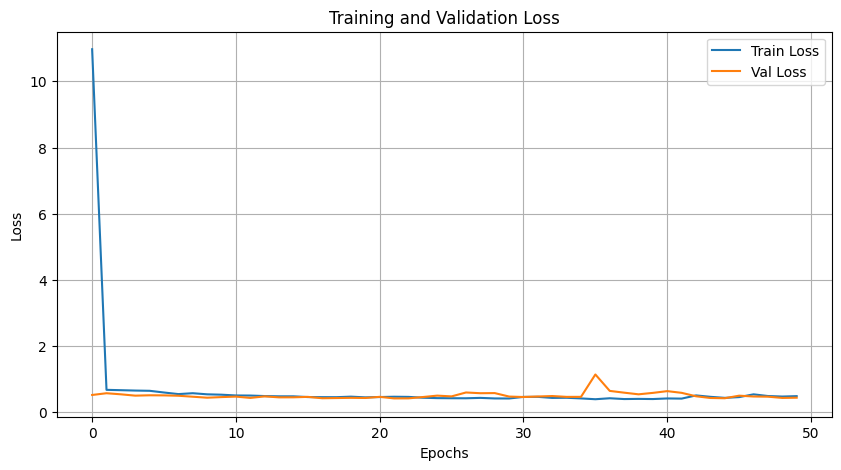

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

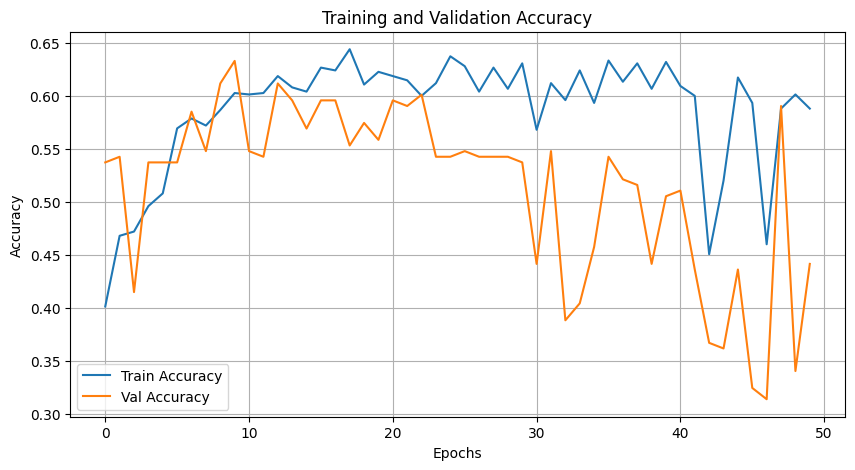

In [ ]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


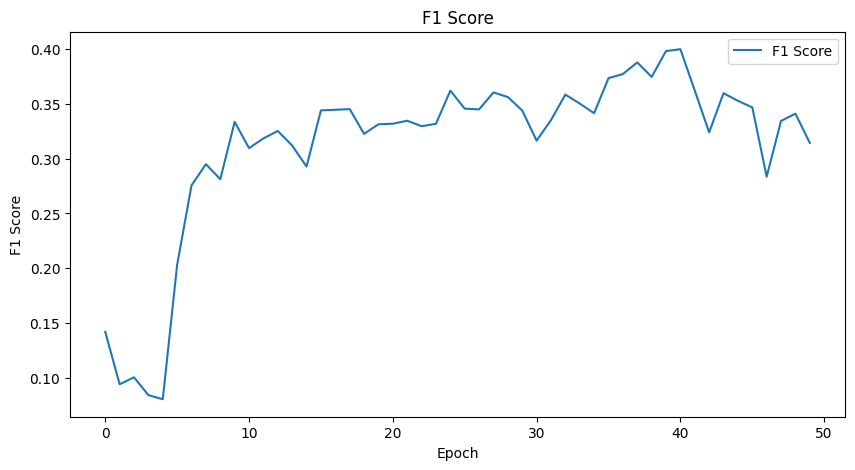

In [ ]:
# Plot F1 score
plt.figure(figsize=(10, 5))
plt.plot(f1_metric, label='F1 Score')
plt.title('F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [ ]:
# Get predictions on test data
y_pred = model.predict(X_test_embeddings_padded)

6/6 [==============================] - 3s 313ms/step


In [ ]:
# Convert probabilities to class labels
y_pred_labels = (y_pred > 0.5).astype(int)

In [ ]:
# Calculate precision
precision = precision_score(y_test, y_pred_labels, average='micro')

# Calculate recall
recall = recall_score(y_test, y_pred_labels, average='micro')

# Calculate F1-score
f1_micro = f1_score(y_test, y_pred_labels, average='micro')
f1_macro = f1_score(y_test, y_pred_labels, average='macro')

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_labels)

# Calculate F1-score
f1 = f1_score(y_test, y_pred_labels, average='micro')

In [ ]:
print("Precision:", precision)
print("Recall:", recall)
print("MicroAvg FScore:", f1_micro*100)
print("MacroAvg FScore:", f1_macro*100)
print("Accuracy:", accuracy*100)

Precision: 1.0
Recall: 0.06046511627906977
MicroAvg FScore: 11.403508771929825
MacroAvg FScore: 9.756290865860908
Accuracy: 6.382978723404255
